# Biomass, synthetic fuels and carbon management

In this example we show how to manage different biomass stocks with different potentials and costs, synthetic fuel production, direct air capture (DAC) and carbon capture and usage/sequestration/cycling (CCU/S/C).

Demand for electricity and diesel transport have to be met from various biomass sources, natural gas with possibility for carbon capture, electrolysis for hydrogen production, direct air capture of CO2, and diesel synthesis via Fischer-Tropsch.

The system has to reach a target of net negative emissions over the period.

All numbers/costs/efficiencies are fictitious to allow easy analysis.


This Jupyter Notebook is also available to download at: http://www.pypsa.org/examples/biomass-synthetic-fuels-carbon-management.ipynb.

It demonstrates features of the energy system modelling tool PyPSA : https://github.com/PyPSA/PyPSA.


In [1]:
import pypsa
import numpy as np

In [2]:
#First tell PyPSA that links can have multiple outputs by
#overriding the component_attrs. This can be done for
#as many buses as you need with format busi for i = 2,3,4,5,....
#See https://pypsa.org/doc/components.html#link-with-multiple-outputs-or-inputs

override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus3"] = ["string",np.nan,np.nan,"3rd bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency3"] = ["static or series","per unit",1.,"3rd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
override_component_attrs["Link"].loc["p3"] = ["series","MW",0.,"3rd bus output","Output"]

In [3]:
n = pypsa.Network(override_component_attrs=override_component_attrs)

n.set_snapshots(range(10))

#add a constant electrical load
n.add("Bus","bus")
n.add("Load","load",bus="bus",
      p_set=1.)

#add a constant demand for transport
n.add("Bus","transport")
n.add("Load","transport",bus="transport",
      p_set=1.)


n.add("Bus","diesel")


n.add("Store","diesel",bus="diesel",
      e_cyclic=True,
      e_nom=1000.)

n.add("Bus","hydrogen")

n.add("Store","hydrogen",bus="hydrogen",
      e_cyclic=True,
      e_nom=1000.)

#n.add("Load","hydrogen",
#      bus="hydrogen",
#      p_set=1.)


n.add("Link","electrolysis",
      p_nom=2.,
      efficiency=0.8,
      bus0="bus",
      bus1="hydrogen")


#Allow production of diesel from H2 and CO2 using Fischer-Tropsch
n.add("Link","FT",
      p_nom=4,
      bus0="hydrogen",
      bus1="diesel",
      bus2="co2 stored",
      efficiency=1.,
      efficiency2=-1)


#minus sign because opposite to how fossil fuels used:
#CH4 burning puts CH4 down, atmosphere up
n.add("Carrier","co2",
      co2_emissions=-1.)

#this tracks CO2 in the atmosphere
n.add("Bus","co2 atmosphere",
      carrier="co2")

#NB: can also be negative
n.add("Store","co2 atmosphere",
      e_nom=1000,
      e_min_pu=-1,
      bus="co2 atmosphere")

#this tracks CO2 stored, e.g. underground
n.add("Bus","co2 stored")

#NB: can also be negative
n.add("Store","co2 stored",
      e_nom = 1000,
      e_min_pu=-1,
      bus="co2 stored")

#direct air capture consumes electricity to take CO2 from the air to the underground store
n.add("Link","DAC",
      bus0="bus",
      bus1="co2 stored",
      bus2 = "co2 atmosphere",
      efficiency=1,
      efficiency2=-1,
      p_nom=5.)


#meet transport with diesel
n.add("Link","diesel car",
      bus0="diesel",
      bus1="transport",
      bus2="co2 atmosphere",
      efficiency=1.,
      efficiency2=1.,
      p_nom=2.)

n.add("Bus","gas")

n.add("Store","gas",
      e_initial=50,
      e_nom=50,
      marginal_cost=20,
      bus="gas")

n.add("Link","OCGT",
      bus0 = "gas",
      bus1 = "bus",
      bus2 = "co2 atmosphere",
      p_nom_extendable=True,
      efficiency = 0.5,
      efficiency2 = 1)


n.add("Link","OCGT+CCS",
      bus0 = "gas",
      bus1 = "bus",
      bus2 = "co2 stored",
      bus3 = "co2 atmosphere",
      p_nom_extendable=True,
      efficiency = 0.4,
      efficiency2 = 0.9,
      efficiency3 = 0.1)



#Cheap and expensive biomass
biomass_marginal_cost = [20.,50.]
biomass_stored = [40.,15.]

for i in range(2):
    n.add("Bus","biomass"+str(i))

    n.add("Store","biomass"+str(i),
          bus="biomass"+str(i),
          e_nom_extendable=True,
          marginal_cost=biomass_marginal_cost[i],
          e_nom=biomass_stored[i],
          e_initial=biomass_stored[i])

    #simultaneously empties and refills co2 atmosphere
    n.add("Link","biomass"+str(i),
          bus0 = "biomass"+str(i),
          bus1 = "bus",
          p_nom_extendable=True,
          efficiency = 0.5)

    n.add("Link","biomass+CCS"+str(i),
          bus0 = "biomass"+str(i),
          bus1 = "bus",
          bus2 = "co2 stored",
          bus3 = "co2 atmosphere",
          p_nom_extendable=True,
          efficiency = 0.4,
          efficiency2 = 1.,
          efficiency3 = -1)


#can go to -50, but at some point can't generate enough electricity for DAC and demand
target = -50

n.add("GlobalConstraint","co2_limit",
      sense="<=",
      carrier_attribute="co2_emissions",
      constant=target)

In [4]:
n.lopf()

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.pf:Slack bus for sub-network 1 is transport
INFO:pypsa.pf:Slack bus for sub-network 2 is diesel
INFO:pypsa.pf:Slack bus for sub-network 3 is hydrogen
INFO:pypsa.pf:Slack bus for sub-network 4 is co2 atmosphere
INFO:pypsa.pf:Slack bus for sub-network 5 is co2 stored
INFO:pypsa.pf:Slack bus for sub-network 6 is gas
INFO:pypsa.pf:Slack bus for sub-network 7 is biomass0
INFO:pypsa.pf:Slack bus for sub-network 8 is biomass1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1916.66666666667
  Upper bound: 1916.66666666667
  Number of objectives: 1
  Number of constraints: 492
  Number of variables: 339
  Number of nonzeros: 987
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.028773784637451172
# ----------------------------------------------------------
#   Solution Information
# --------

('ok', 'optimal')

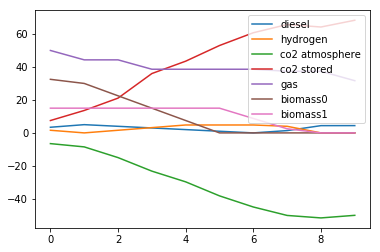

In [5]:
n.stores_t.e.plot()

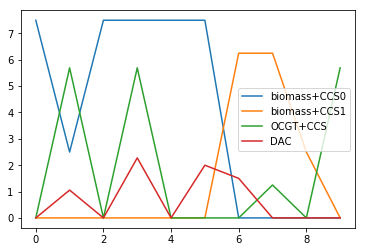

In [6]:
n.links_t.p0[["biomass+CCS0","biomass+CCS1","OCGT+CCS","DAC"]].plot()

In [7]:
#at all times, the amount of carbon is constant
n.stores_t.e[["co2 stored","co2 atmosphere","gas","diesel"]].sum(axis=1)

0    54.422222
1    54.422222
2    54.422222
3    54.422222
4    54.422222
5    54.422222
6    54.422222
7    54.422222
8    54.422222
9    54.422222
dtype: float64